In [12]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f:  
    DCBS_DataFrame = pickle.load(f)
    

with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)


with open('database_ByZCG\\A_ConvertibleBondTimeSeries_DataFrame.pkl', 'rb') as f:  
    A_ConvertibleBondTimeSeries_DataFrame = pickle.load(f)
    
# re-open
with open(DTBS_path, 'rb') as f:  
    DTBS = pickle.load(f)
    
# 只提取A区中存活的转债的时间序列信息
A_DF = A_ConvertibleBondTimeSeries_DataFrame[A_ConvertibleBondTimeSeries_DataFrame['ia']==1].copy()

# 提取B区信息
B_DF = DTBS_DataFrame['B']
# 计算所有转债每天的涨跌幅，并找出涨幅大于前N个交易日的q分位数涨跌幅的均值的转债

print(A_DF)

                      bond_code        date      cpr       dp    bl      trt  \
id                                                                             
110088.SH,2022-10-20  110088.SH  2022-10-20  26.5079  128.009  30.0  44.3197   
110088.SH,2022-10-21  110088.SH  2022-10-21  25.9716  129.044  30.0  14.9064   
110088.SH,2022-10-24  110088.SH  2022-10-24  26.2993  125.883  30.0   4.4837   
110088.SH,2022-10-25  110088.SH  2022-10-25  31.2340  126.303  30.0   2.6031   
110088.SH,2022-10-26  110088.SH  2022-10-26  34.1045  126.502  30.0   2.2618   
...                         ...         ...      ...      ...   ...      ...   
118036.SH,2023-07-27  118036.SH  2023-07-27  47.0500  135.229   3.8   8.7100   
118036.SH,2023-07-28  118036.SH  2023-07-28  48.9300  138.455   3.8  13.8600   
123202.SZ,2023-07-26  123202.SZ  2023-07-26  33.6900  135.117   4.6  14.4500   
123202.SZ,2023-07-27  123202.SZ  2023-07-27  31.3300  133.000   4.6  81.7200   
123202.SZ,2023-07-28  123202.SZ  2023-07

In [13]:
def bond_code_to_pure_number(x):
    return x[0:6]

A_DF['pure_number_bond_code'] = A_DF['bond_code'].apply(lambda x : int(x[0:6]))
A_DF = A_DF.copy()
print(A_DF)

                      bond_code        date      cpr       dp    bl      trt  \
id                                                                             
110088.SH,2022-10-20  110088.SH  2022-10-20  26.5079  128.009  30.0  44.3197   
110088.SH,2022-10-21  110088.SH  2022-10-21  25.9716  129.044  30.0  14.9064   
110088.SH,2022-10-24  110088.SH  2022-10-24  26.2993  125.883  30.0   4.4837   
110088.SH,2022-10-25  110088.SH  2022-10-25  31.2340  126.303  30.0   2.6031   
110088.SH,2022-10-26  110088.SH  2022-10-26  34.1045  126.502  30.0   2.2618   
...                         ...         ...      ...      ...   ...      ...   
118036.SH,2023-07-27  118036.SH  2023-07-27  47.0500  135.229   3.8   8.7100   
118036.SH,2023-07-28  118036.SH  2023-07-28  48.9300  138.455   3.8  13.8600   
123202.SZ,2023-07-26  123202.SZ  2023-07-26  33.6900  135.117   4.6  14.4500   
123202.SZ,2023-07-27  123202.SZ  2023-07-27  31.3300  133.000   4.6  81.7200   
123202.SZ,2023-07-28  123202.SZ  2023-07

In [14]:
# DataFrame新增列用于存放前一天收盘价、涨跌幅
A_DF['lastday_dp'] = np.nan
A_DF['change'] = np.nan
A_DF['sn'] = np.nan

A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
bond_codes_list = list(set(A_DF['bond_code']))

i = 1
for bond_code in bond_codes_list:
    dp_list = list(A_DF.loc[A_DF['bond_code']==bond_code,'dp'])
    lastday_dp_list = dp_list[:-1]
    lastday_dp_list.insert(0,np.nan)
    # print(dp_list,'\n',lastday_dp_list)
    change_list = [(dp_list[i] - lastday_dp_list[i]) / lastday_dp_list[i] for i in range(1,len(dp_list))]
    change_list.insert(0,np.nan)
    A_DF.loc[A_DF['bond_code']==bond_code,'lastday_dp'] = lastday_dp_list
    A_DF.loc[A_DF['bond_code']==bond_code,'change'] = change_list
    A_DF.loc[A_DF['bond_code']==bond_code,'sn'] = DTBS['B'][bond_code]['sn']
    
    # 观察程序进度，没有其他任何功能
    print(i)
    i = i + 1
    
print(A_DF)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [15]:
# 获取最后一天的日期
last_day_date = sorted(list(set(A_DF['date'])))[-1]
print(last_day_date)

2023-07-28


In [16]:
import pandas as pd
df = pd.read_excel('C:\\Users\\goodluck\\Desktop\\0731.xlsx')
print(df)

output_df = pd.merge(df, A_DF.loc[A_DF['date']==last_day_date, ['pure_number_bond_code','bond_code','change','dl']],left_on='证券代码', right_on='pure_number_bond_code')
del output_df['pure_number_bond_code']

print(output_df)

      证券代码  证券名称
0   110070  凌钢转债
1   113519  长久转债
2   113527  维格转债
3   113563  柳药转债
4   113628  晨丰转债
5   113651  松霖转债
6   118029  富淼转债
7   123059  银信转债
8   123100  朗科转债
9   123153  英力转债
10  123160  泰福转债
11  123162  东杰转债
12  123168  惠云转债
13  123169  正海转债
14  127053  豪美转债
15  127054  双箭转债
16  127055  精装转债
17  127076  中宠转2
18  127078  优彩转债
19  128105  长集转债
20  128141  旺能转债
      证券代码  证券名称  bond_code    change       dl
0   110070  凌钢转债  110070.SH  0.018828  155.845
1   113519  长久转债  113519.SH  0.011764  152.455
2   113527  维格转债  113527.SH  0.004268  151.681
3   113563  柳药转债  113563.SH  0.006847  159.765
4   113628  晨丰转债  113628.SH  0.000343  140.156
5   113651  松霖转债  113651.SH  0.012433  161.249
6   118029  富淼转债  118029.SH  0.009698  156.241
7   123059  银信转债  123059.SZ  0.001531  162.860
8   123100  朗科转债  123100.SZ  0.003680  160.178
9   123153  英力转债  123153.SZ -0.003726  159.905
10  123160  泰福转债  123160.SZ  0.005929  145.928
11  123162  东杰转债  123162.SZ  0.001102  141.978
12  123168  惠云转

In [17]:
day_list  = sorted(list(set(A_DF['date'])))
print(day_list)

"""
设置分位点，时间参数（这些参数可以后期调整）；
q_change（判定债券是否热门的分位点），q_dl（判定债券双低是否较低的分位点）
n(用前n天作为一个周期看债券之前是否热门),m（一个周期内需要几天涨幅较大超过分位点才能认为这只债券之前是热门债券）
"""

q_change = 0.95
n = 10
m = 1 

# 使用数据从'2023-04-27'-'2023-07-13',实际测试时间从'2023-5-18'-'2023-07-13',因为需要测试日的前10个交易日的数据去观察这个债券之前是否热门
start_index = day_list.index('2023-01-03')
end_index = day_list.index('2023-07-28')

day_list = day_list[start_index:end_index+1]
test_day_list = day_list[n+1:]


# 最后需要展示的列
need_columns = ['date' ,'bond_code' ,'dp','sn','change', 'dl','cpr','bl','yl']
output_columns = ['date' ,'bond_code' ,'dp','sn','change', 'dl','cpr','bl','yl']

empty_df_select = pd.DataFrame(columns = need_columns)

history_hot_codes_Dict = {}


# 这个循环是为了找出历史上每天位于规定的涨幅分位点之前的债券代码，用一个字典存放（Key:日期，Value:存放债券代码的列表）

for day_index in range(1,len(day_list)):
        change_list = list(A_DF[A_DF['date'] == day_list[day_index]]['change'].dropna())
        
        change_quantile = np.quantile(change_list, q_change)
        
        # print(change_quantile)
        
        # 挑出每天的热门债券代码
        ervery_day_hot_codes = list(A_DF.loc[(A_DF['date'] == day_list[day_index]) & (A_DF['change'] >= change_quantile), 'bond_code'])
        history_hot_codes_Dict[day_list[day_index]] = ervery_day_hot_codes

print(history_hot_codes_Dict)
        
       
for test_day in test_day_list:
    
    test_day_index = day_list.index(test_day)
    
    test_day_codes = list(A_DF.loc[A_DF['date'] == test_day,'bond_code'])
      
    # print(day_list[test_day_index],day_list[test_day_index-n])
    # print(test_day_codes)
        
    last_n_days_hot_codes = []
    for day_index in range(test_day_index - n,test_day_index):
        last_n_days_hot_codes.extend(history_hot_codes_Dict[day_list[day_index]])
    # print(last_n_days_hot_codes)
    
    hot_codes = []
    for code in set(last_n_days_hot_codes):
        # 某只债券在前n天有大于等于m天属于热门债券，并且这只债券在今天还活跃
        if (last_n_days_hot_codes.count(code) >= m) and (code in test_day_codes): 
            hot_codes.append(code)
    
    # 筛选出某天所有既是热门债券，
    df = A_DF.loc[(A_DF['date'] == test_day) & (A_DF['bond_code'].isin(hot_codes))].copy()
    
    
    pd.set_option('display.width', 500)
    # df.rename(columns={'date' : '日期','bond_code' : '可转债代码','cn' : '转债中文名','sc' : '正股代码','sn' : '正股中文名','dp' : '收盘价（全价）','lastday_dp':'前一日收盘价','cpr' : '转股溢价率','dl' : '双低','change':'涨跌幅'},inplace=True)
    # df_show = df[['日期','可转债代码','转债中文名','正股代码','正股中文名','收盘价（全价）', '前一日收盘价','转股溢价率','双低','涨跌幅']]
        
    df_select = df[need_columns].copy()
    # print(df_select)    
    empty_df_select = pd.concat([empty_df_select,df_select])

empty_df_select.sort_values(by = ['date','change','dl'], inplace=True, ascending=[True,False,True])


# 最终结果
print(empty_df_select.to_string(index=True))

today_hot_bond_code_list_5_percent = list(empty_df_select[empty_df_select['date'] == last_day_date]['bond_code'])
dangrishifouremen_5_percent = history_hot_codes_Dict[last_day_date]
print(today_hot_bond_code_list_5_percent)

['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-02-03', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14', '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20', '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-27', '2017-03-28', '2017-03-29', '2017-03-30', '2017-03-31', '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-10', '2017-04-11', '2017-04-12', '2017-04-13', '2017-04-14', '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20', '2017

{'2023-01-04': ['110043.SH', '110047.SH', '110063.SH', '111007.SH', '113047.SH', '113542.SH', '113597.SH', '113598.SH', '113625.SH', '118022.SH', '123013.SZ', '123015.SZ', '123018.SZ', '123034.SZ', '123071.SZ', '123080.SZ', '123098.SZ', '123116.SZ', '123154.SZ', '127033.SZ', '127044.SZ', '127058.SZ', '127069.SZ', '128130.SZ'], '2023-01-05': ['110048.SH', '111000.SH', '111006.SH', '111008.SH', '113534.SH', '113537.SH', '113585.SH', '113641.SH', '113652.SH', '118019.SH', '123046.SZ', '123057.SZ', '123060.SZ', '123098.SZ', '123134.SZ', '123147.SZ', '123148.SZ', '127037.SZ', '127058.SZ', '127064.SZ', '127069.SZ', '128078.SZ', '128095.SZ', '128111.SZ'], '2023-01-06': ['110085.SH', '113027.SH', '113059.SH', '113061.SH', '113064.SH', '113534.SH', '113537.SH', '113626.SH', '113661.SH', '118008.SH', '123012.SZ', '123046.SZ', '123085.SZ', '123092.SZ', '123165.SZ', '127030.SZ', '127037.SZ', '128017.SZ', '128040.SZ', '128056.SZ', '128079.SZ', '128095.SZ', '128111.SZ', '128140.SZ'], '2023-01-09': [

                            date  bond_code       dp     sn    change        dl       cpr          bl        yl
128111.SZ,2023-01-18  2023-01-18  128111.SZ  825.300   中矿资源  0.060797  834.6448    9.3448    1.146900  3.394500
128078.SZ,2023-01-18  2023-01-18  128078.SZ  181.000   太极股份  0.049275  193.6518   12.6518    6.948700  2.756200
110068.SH,2023-01-18  2023-01-18  110068.SH  170.344   龙净环保  0.039069  174.7811    4.4371   19.751100  3.178100
110052.SH,2023-01-18  2023-01-18  110052.SH  198.295   贵广网络  0.030693  202.4261    4.1311    2.921000  2.126000
113537.SH,2023-01-18  2023-01-18  113537.SH  387.262   文灿股份  0.027212  398.5983   11.3363    1.239200  2.391800
110088.SH,2023-01-18  2023-01-18  110088.SH  123.232   淮北矿业  0.026942  162.0166   38.7846   30.000000  5.654800
123092.SZ,2023-01-18  2023-01-18  123092.SZ  245.300   天壕能源  0.024517  247.3099    2.0099    4.141900  3.931500
123083.SZ,2023-01-18  2023-01-18  123083.SZ  198.600   朗新科技  0.023711  216.9812   18.3812    5.482600  3

In [18]:
day_list  = sorted(list(set(A_DF['date'])))
print(day_list)

"""
设置分位点，时间参数（这些参数可以后期调整）；
q_change（判定债券是否热门的分位点），q_dl（判定债券双低是否较低的分位点）
n(用前n天作为一个周期看债券之前是否热门),m（一个周期内需要几天涨幅较大超过分位点才能认为这只债券之前是热门债券）
"""

q_change = 0.9
n = 10
m = 1 

# 使用数据从'2023-04-27'-'2023-07-13',实际测试时间从'2023-5-18'-'2023-07-13',因为需要测试日的前10个交易日的数据去观察这个债券之前是否热门
start_index = day_list.index('2023-01-03')
end_index = day_list.index('2023-07-28')

day_list = day_list[start_index:end_index+1]
test_day_list = day_list[n+1:]


# 最后需要展示的列
need_columns = ['date' ,'bond_code' ,'dp','sn','change', 'dl','cpr','bl','yl']
output_columns = ['date' ,'bond_code' ,'dp','sn','change', 'dl','cpr','bl','yl']

empty_df_select = pd.DataFrame(columns = need_columns)

history_hot_codes_Dict = {}


# 这个循环是为了找出历史上每天位于规定的涨幅分位点之前的债券代码，用一个字典存放（Key:日期，Value:存放债券代码的列表）

for day_index in range(1,len(day_list)):
        change_list = list(A_DF[A_DF['date'] == day_list[day_index]]['change'].dropna())
        
        change_quantile = np.quantile(change_list, q_change)
        
        # print(change_quantile)
        
        # 挑出每天的热门债券代码
        ervery_day_hot_codes = list(A_DF.loc[(A_DF['date'] == day_list[day_index]) & (A_DF['change'] >= change_quantile), 'bond_code'])
        history_hot_codes_Dict[day_list[day_index]] = ervery_day_hot_codes

print(history_hot_codes_Dict)
        
       
for test_day in test_day_list:
    
    test_day_index = day_list.index(test_day)
    
    test_day_codes = list(A_DF.loc[A_DF['date'] == test_day,'bond_code'])
      
    # print(day_list[test_day_index],day_list[test_day_index-n])
    # print(test_day_codes)
        
    last_n_days_hot_codes = []
    for day_index in range(test_day_index - n,test_day_index):
        last_n_days_hot_codes.extend(history_hot_codes_Dict[day_list[day_index]])
    # print(last_n_days_hot_codes)
    
    hot_codes = []
    for code in set(last_n_days_hot_codes):
        # 某只债券在前n天有大于等于m天属于热门债券，并且这只债券在今天还活跃
        if (last_n_days_hot_codes.count(code) >= m) and (code in test_day_codes): 
            hot_codes.append(code)
    
    # 筛选出某天所有既是热门债券，
    df = A_DF.loc[(A_DF['date'] == test_day) & (A_DF['bond_code'].isin(hot_codes))].copy()
    
    
    pd.set_option('display.width', 500)
    # df.rename(columns={'date' : '日期','bond_code' : '可转债代码','cn' : '转债中文名','sc' : '正股代码','sn' : '正股中文名','dp' : '收盘价（全价）','lastday_dp':'前一日收盘价','cpr' : '转股溢价率','dl' : '双低','change':'涨跌幅'},inplace=True)
    # df_show = df[['日期','可转债代码','转债中文名','正股代码','正股中文名','收盘价（全价）', '前一日收盘价','转股溢价率','双低','涨跌幅']]
        
    df_select = df[need_columns].copy()
    # print(df_select)    
    empty_df_select = pd.concat([empty_df_select,df_select])

empty_df_select.sort_values(by = ['date','change','dl'], inplace=True, ascending=[True,False,True])


# 最终结果
print(empty_df_select.to_string(index=True))

today_hot_bond_code_list_10_percent = list(empty_df_select[empty_df_select['date'] == last_day_date]['bond_code'])
dangrishifouremen_10_percent = history_hot_codes_Dict[last_day_date]
print(today_hot_bond_code_list_10_percent)

['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-02-03', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14', '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20', '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-27', '2017-03-28', '2017-03-29', '2017-03-30', '2017-03-31', '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-10', '2017-04-11', '2017-04-12', '2017-04-13', '2017-04-14', '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20', '2017

{'2023-01-04': ['110043.SH', '110044.SH', '110047.SH', '110053.SH', '110063.SH', '110083.SH', '110086.SH', '111007.SH', '113047.SH', '113055.SH', '113058.SH', '113542.SH', '113579.SH', '113594.SH', '113597.SH', '113598.SH', '113623.SH', '113625.SH', '113658.SH', '113663.SH', '118022.SH', '123013.SZ', '123015.SZ', '123018.SZ', '123034.SZ', '123071.SZ', '123080.SZ', '123083.SZ', '123098.SZ', '123116.SZ', '123130.SZ', '123133.SZ', '123154.SZ', '127033.SZ', '127044.SZ', '127047.SZ', '127058.SZ', '127062.SZ', '127069.SZ', '128034.SZ', '128048.SZ', '128082.SZ', '128130.SZ', '128134.SZ', '128135.SZ', '128140.SZ', '128142.SZ'], '2023-01-05': ['110048.SH', '110068.SH', '110074.SH', '110076.SH', '111000.SH', '111006.SH', '111008.SH', '113534.SH', '113537.SH', '113579.SH', '113585.SH', '113622.SH', '113629.SH', '113641.SH', '113649.SH', '113652.SH', '118013.SH', '118019.SH', '118023.SH', '123046.SZ', '123057.SZ', '123060.SZ', '123067.SZ', '123071.SZ', '123098.SZ', '123105.SZ', '123119.SZ', '12313

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
dl_quantile_30_percent = np.quantile(list(A_DF[A_DF['date'] == '2023-07-28']['dl']),0.3)
dl_quantile_50_percent = np.quantile(list(A_DF[A_DF['date'] == '2023-07-28']['dl']),0.5)
print(dl_quantile_30_percent,dl_quantile_50_percent)
  
    
output_df['前10个交易日是否热门(5%)'] = output_df['bond_code'].apply(lambda x : '是' if x in today_hot_bond_code_list_5_percent else '否')
output_df['前10个交易日是否热门(10%)'] = output_df['bond_code'].apply(lambda x : '是' if x in today_hot_bond_code_list_10_percent else '否')
output_df['当日是否热门(5%)'] = output_df['bond_code'].apply(lambda x : '是' if x in dangrishifouremen_5_percent else '否')
output_df['当日是否热门(10%)'] = output_df['bond_code'].apply(lambda x : '是' if x in dangrishifouremen_10_percent else '否')
output_df['当日是否位于双低前(30%)'] = output_df['dl'].apply(lambda x: '是' if x <= dl_quantile_30_percent else '否')
output_df['当日是否位于双低前(50%)'] = output_df['dl'].apply(lambda x: '是' if x <= dl_quantile_50_percent else '否')

print(output_df)

155.9734 168.14600000000002
      证券代码  证券名称  bond_code    change       dl 前10个交易日是否热门(5%) 前10个交易日是否热门(10%) 当日是否热门(5%) 当日是否热门(10%) 当日是否位于双低前(30%) 当日是否位于双低前(50%)
0   110070  凌钢转债  110070.SH  0.018828  155.845               是                是          否           是              是              是
1   113519  长久转债  113519.SH  0.011764  152.455               是                是          否           否              是              是
2   113527  维格转债  113527.SH  0.004268  151.681               否                否          否           否              是              是
3   113563  柳药转债  113563.SH  0.006847  159.765               否                是          否           否              否              是
4   113628  晨丰转债  113628.SH  0.000343  140.156               否                是          否           否              是              是
5   113651  松霖转债  113651.SH  0.012433  161.249               否                否          否           否              否              是
6   118029  富淼转债  118029.SH  0.009698  15

In [27]:
output_df.to_excel('C:\\Users\\goodluck\\Desktop\\output.xlsx')

In [24]:
change_list = A_DF.loc[A_DF['date']=='2023-07-28', 'change']
change_quantile = np.quantile(change_list, 0.95)
print('2023-07-28前5%：', change_quantile)
change_quantile = np.quantile(change_list, 0.90)
print('2023-07-28前10%：', change_quantile)

2023-07-28前5%： 0.023759634433437246
2023-07-28前10%： 0.016428818377193597


In [25]:
day_list  = sorted(list(set(A_DF['date'])))
print(day_list)

"""
设置分位点，时间参数（这些参数可以后期调整）；
q_change（判定债券是否热门的分位点），q_dl（判定债券双低是否较低的分位点）
n(用前n天作为一个周期看债券之前是否热门),m（一个周期内需要几天涨幅较大超过分位点才能认为这只债券之前是热门债券）
"""

# 使用数据从'2023-04-27'-'2023-07-13',实际测试时间从'2023-5-18'-'2023-07-13',因为需要测试日的前10个交易日的数据去观察这个债券之前是否热门
start_index = day_list.index('2023-05-04')
end_index = day_list.index('2023-07-28')

day_list = day_list[start_index:end_index+1]
test_day_list = day_list[n+1:]


# 最后需要展示的列
need_columns = ['date' ,'bond_code' ,'dp','sn','change', 'dl','cpr','bl','yl']
output_columns = ['date' ,'bond_code' ,'dp','sn','change', 'dl','cpr','bl','yl']

empty_df_select = pd.DataFrame(columns = need_columns)

history_hot_codes_Dict = {}
q_change_95_percent_Dict = {}
q_change_90_percent_Dict = {}
q_dl_30_percent_Dict = {}
q_dl_50_percent_Dict = {}

q_change_95_percent_list = []
q_change_90_percent_list = []
q_dl_30_percent_list = []
q_dl_50_percent_list = []


# 这个循环是为了找出历史上每天位于规定的涨幅分位点之前的债券代码，用一个字典存放（Key:日期，Value:存放债券代码的列表）

for day_index in range(1,len(day_list)):
        change_list = list(A_DF[A_DF['date'] == day_list[day_index]]['change'].dropna())
        dl_list = list(A_DF[A_DF['date'] == day_list[day_index]]['dl'].dropna())
        
        change_quantile_95_percent = np.quantile(change_list, 0.95)
        change_quantile_90_percent = np.quantile(change_list, 0.9)
        dl_quantile_30_percent = np.quantile(dl_list, 0.3)
        dl_quantile_50_percent = np.quantile(dl_list, 0.5)
        
        history_hot_codes_Dict[day_list[day_index]] = ervery_day_hot_codes
        q_change_95_percent_Dict[day_list[day_index]] = change_quantile_95_percent
        q_change_90_percent_Dict[day_list[day_index]] = change_quantile_90_percent
        q_dl_30_percent_Dict[day_list[day_index]] = dl_quantile_30_percent
        q_dl_50_percent_Dict[day_list[day_index]] = dl_quantile_50_percent
        q_change_95_percent_list.append(change_quantile_95_percent)
        q_change_90_percent_list.append(change_quantile_90_percent)
        q_dl_30_percent_list.append(dl_quantile_30_percent)
        q_dl_50_percent_list.append(dl_quantile_50_percent)
        
print(history_hot_codes_Dict, '\n', q_change_95_percent_Dict, '\n', q_change_90_percent_Dict, '\n', q_dl_30_percent_Dict, '\n', q_dl_50_percent_Dict)

print(sum(q_change_95_percent_list[-5:])/5, sum(q_change_90_percent_list[-5:])/5, sum(q_dl_30_percent_list[-5:])/5, sum(q_dl_50_percent_list[-5:])/5)
print(q_change_95_percent_list[-5:], '\n', q_change_90_percent_list[-5:], '\n', q_dl_30_percent_list[-5:], '\n', q_dl_50_percent_list[-5:])

['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-02-03', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14', '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20', '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-27', '2017-03-28', '2017-03-29', '2017-03-30', '2017-03-31', '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-10', '2017-04-11', '2017-04-12', '2017-04-13', '2017-04-14', '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20', '2017

{'2023-05-05': ['110043.SH', '110048.SH', '110058.SH', '110067.SH', '110070.SH', '110073.SH', '110083.SH', '111004.SH', '111009.SH', '111014.SH', '113024.SH', '113025.SH', '113037.SH', '113055.SH', '113057.SH', '113060.SH', '113062.SH', '113504.SH', '113530.SH', '113601.SH', '113615.SH', '113625.SH', '113655.SH', '113658.SH', '118009.SH', '118036.SH', '123013.SZ', '123015.SZ', '123092.SZ', '123154.SZ', '123172.SZ', '123188.SZ', '123191.SZ', '123192.SZ', '123200.SZ', '123201.SZ', '127005.SZ', '127006.SZ', '127014.SZ', '127016.SZ', '127020.SZ', '127029.SZ', '127030.SZ', '127032.SZ', '127033.SZ', '127044.SZ', '127050.SZ', '128095.SZ', '128114.SZ', '128116.SZ', '128134.SZ'], '2023-05-08': ['110043.SH', '110048.SH', '110058.SH', '110067.SH', '110070.SH', '110073.SH', '110083.SH', '111004.SH', '111009.SH', '111014.SH', '113024.SH', '113025.SH', '113037.SH', '113055.SH', '113057.SH', '113060.SH', '113062.SH', '113504.SH', '113530.SH', '113601.SH', '113615.SH', '113625.SH', '113655.SH', '11365

<Figure size 36000x18000 with 0 Axes>

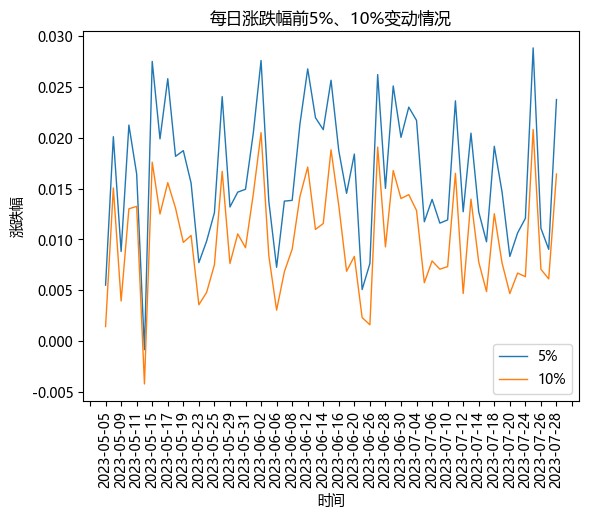

<Figure size 36000x18000 with 0 Axes>

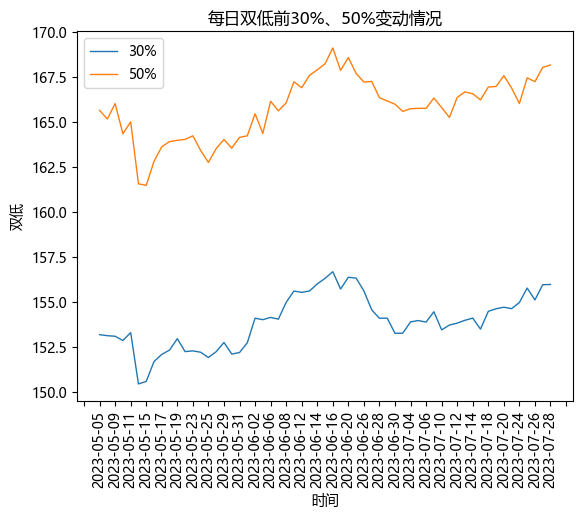

In [26]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题


plt.figure(figsize=(30,15),dpi=1200)
fig, ax = plt.subplots(1, 1)
plt.plot(q_change_95_percent_Dict.keys(), q_change_95_percent_Dict.values(),label='5%',linewidth=1)
plt.plot(q_change_90_percent_Dict.keys(), q_change_90_percent_Dict.values(),label='10%',linewidth=1)
plt.xlabel("时间")
plt.ylabel("涨跌幅")
plt.title('每日涨跌幅前5%、10%变动情况')
# 图例显示
plt.legend()
# 设置打印的密度
# tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()


plt.figure(figsize=(30,15),dpi=1200)
fig, ax = plt.subplots(1, 1)
plt.plot(q_dl_30_percent_Dict.keys(), q_dl_30_percent_Dict.values(),label='30%',linewidth=1)
plt.plot(q_dl_50_percent_Dict.keys(), q_dl_50_percent_Dict.values(),label='50%',linewidth=1)
plt.xlabel("时间")
plt.ylabel("双低")
plt.title('每日双低前30%、50%变动情况')
# 图例显示
plt.legend()
# 设置打印的密度
# tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()